In [1]:
import sys
sys.path.append('../../paper/experiments')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils
import joblib
import pandas as pd
from run_experiment import run_experiment
import pmsurv_exponential 
import pmsurv_weibull
import pmsurv_weibull_nn
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from pmsurv.models.exponential_model import ExponentialModel
from pmsurv.models.weibull_linear import WeibullModelLinear
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmsurv
import pymc as pm
import numpy as np
from sklearn.pipeline import Pipeline

print(pm.__version__)

5.1.2


In [4]:
RETRAIN = False

In [5]:
SEED = 42

In [6]:
dataset, config = utils.load_data('../../paper/experiments/data/veteran')
train_kwargs = {'jobs': 5, 'n_iter': 10}
# continuous_features = config['preprocessing']['continuous_features']

In [7]:
dataset['celltype_1:trt'] = dataset['celltype_1'] * dataset['trt_2']
dataset['celltype_2:trt'] = dataset['celltype_2'] * dataset['trt_2']
dataset['celltype_3:trt'] = dataset['celltype_3'] * dataset['trt_2']
dataset['celltype_4:trt'] = dataset['celltype_4'] * dataset['trt_2']

config['features'] = ['age', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
config['preprocessing']['standardize'] = True
config['preprocessing']['continuous_features'] = ['age']
continuous_features = config['preprocessing']['continuous_features']

In [8]:
dataset

,age,karno,diagtime,prior_10,trt_2,celltype_1,celltype_2,celltype_3,celltype_4,time,status,celltype_1:trt,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,69,60,7,0.0,0.0,1.0,0.0,0.0,0.0,72,1,0.0,0.0,0.0,0.0
1,64,70,5,1.0,0.0,1.0,0.0,0.0,0.0,411,1,0.0,0.0,0.0,0.0
2,38,60,3,0.0,0.0,1.0,0.0,0.0,0.0,228,1,0.0,0.0,0.0,0.0
3,63,60,9,1.0,0.0,1.0,0.0,0.0,0.0,126,1,0.0,0.0,0.0,0.0
4,65,70,11,1.0,0.0,1.0,0.0,0.0,0.0,118,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,65,75,1,0.0,1.0,0.0,0.0,0.0,1.0,133,1,0.0,0.0,0.0,1.0
133,64,60,5,0.0,1.0,0.0,0.0,0.0,1.0,111,1,0.0,0.0,0.0,1.0
134,67,70,18,1.0,1.0,0.0,0.0,0.0,1.0,231,1,0.0,0.0,0.0,1.0
135,65,80,4,0.0,1.0,0.0,0.0,0.0,1.0,378,1,0.0,0.0,0.0,1.0


In [9]:
X_predict_original = pd.DataFrame({
    'age': [50, 50, 65, 65],
    # 'diagtime': [5, 5, 5, 5],
    'trt_2': [0, 0, 1, 0],
    # 'prior_10': [0, 0, 0, 0],
    # 'celltype_1': [1, 1, 0, 0], 
    'celltype_2': [0, 0, 1, 1], 
    'celltype_3': [1, 1, 0, 0], 
    'celltype_4': [0, 0, 0, 0], 
    'celltype_2:trt': [0, 0, 1, 0], 
    'celltype_3:trt': [1, 0, 0, 0],  
    'celltype_4:trt': [0, 0, 0, 0],
    # 'karno': [80, 80, 80, 80]
})
# X_predict_original = dataset[config['features']]
X_predict_original

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,50,0,0,1,0,0,1,0
1,50,0,0,1,0,0,0,0
2,65,1,1,0,0,1,0,0
3,65,0,1,0,0,0,0,0


## Train function

In [10]:
def train_model_generic(dataset, config, train_kwargs, preprocess_data_fun, train_fun):
    dataset = dataset.dropna(subset=config['features'])
    X, y = preprocess_data_fun(dataset, config)
    print(X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=config['split']['test_size'],
                                                        shuffle=config['split']['shuffle'])

    if config['preprocessing']['standardize']:
        X_train, X_test, scaler = utils.standardize(X_train, X_test, config)
    else:
        scaler = None

    pipeline, parameters, fit_params = train_fun(X_train, y_train, config, train_kwargs)
    n_cv = 5
    n_points = int(train_kwargs['jobs'] / n_cv)
    opt = BayesSearchCV(pipeline, parameters,
                        fit_params=fit_params,
                        n_jobs=train_kwargs['jobs'],
                        n_points=n_points if n_points > 1 else 1,
                        n_iter=train_kwargs['n_iter'],
                        cv=n_cv,
                        error_score='raise')
    opt.fit(X_train, y_train)
    metrics = opt.best_estimator_.score(X_test, y_test)
    print("Test metrics: " + str(metrics))

    return metrics, opt.best_estimator_, opt.best_params_, scaler, (X_train, X_test, y_train, y_test)

# Exponential

In [11]:
if RETRAIN:
    metrics, model_e, best_params_e, scaler_e, data_e = train_model_generic(dataset, config, train_kwargs, pmsurv_exponential.preprocess_data, pmsurv_exponential.train_model)
    print(f"score {metrics:0.3f}")

In [12]:
if RETRAIN:
    joblib.dump(model_e['selector'], 'models/exp/selector.pkl')
    joblib.dump(scaler_e, 'models/exp/scaler.pkl')
    joblib.dump(data_e, 'models/exp/data.pkl')
    model_e['model'].save('models/exp/model.yaml')

In [13]:
model_e_m = ExponentialModel()
model_e_m.load('models/exp/model.yaml')
model_e = Pipeline([
    ('selector', joblib.load('models/exp/selector.pkl')),
    ('model', model_e_m),
])

scaler_e = joblib.load('models/exp/scaler.pkl')
data_e = joblib.load('models/exp/data.pkl')


In [14]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_e.transform(X_predict[continuous_features])
surv_e, surv_e_lower, surv_e_upper = model_e.predict(X_predict)
t_plot_e = pmsurv.utils.get_time_axis(0, model_e['model'].max_time, 10)
print(model_e['model'].max_time)

Sampling: []


32


## Plot

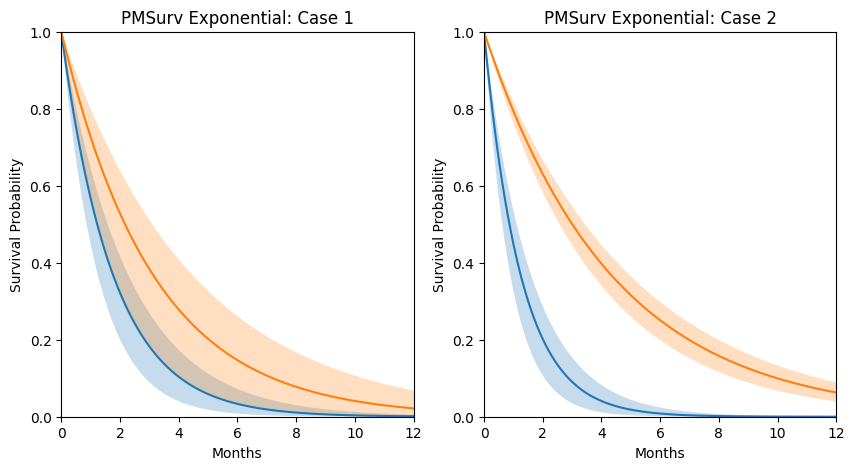

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Exponential: Case 1");
plt.plot(t_plot_e, surv_e[0]);
plt.fill_between(t_plot_e, y1=surv_e_lower[0], y2=surv_e_upper[0], alpha=0.25);
plt.plot(t_plot_e, surv_e[1]);
plt.fill_between(t_plot_e, y1=surv_e_lower[1], y2=surv_e_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.ylabel("Survival Probability");
plt.xlabel("Months");
plt.xlim(0, 12);

plt.subplot(1, 2, 2)
plt.title("PMSurv Exponential: Case 2");
plt.plot(t_plot_e, surv_e[2]);
plt.fill_between(t_plot_e, y1=surv_e_lower[2], y2=surv_e_upper[2], alpha=0.25);
plt.plot(t_plot_e, surv_e[3]);
plt.fill_between(t_plot_e, y1=surv_e_lower[3], y2=surv_e_upper[3], alpha=0.25);
plt.ylim(0, 1)
plt.ylabel("Survival Probability");
plt.xlabel("Months");
plt.xlim(0, 12);

# Weibull

In [16]:
import pmsurv_weibull

In [17]:
if RETRAIN:
    metrics, model_wb, best_params_wb, scaler_wb, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull.preprocess_data, pmsurv_weibull.train_model)

In [18]:
if RETRAIN:
    joblib.dump(model_wb['selector'], 'models/wb/selector.pkl')
    joblib.dump(scaler_wb, 'models/wb/scaler.pkl')
    model_wb['model'].save('models/wb/model.yaml')

In [19]:
model_wb_m = WeibullModelLinear()
model_wb_m.load('models/wb/model.yaml')
model_wb = Pipeline([
    ('selector', joblib.load('models/wb/selector.pkl')),
    ('model', model_wb_m),
])
scaler_wb = joblib.load('models/wb/scaler.pkl')

load:  {'k_coefs': False, 'k_coefs_mu': 0, 'k_coefs_sd': 1, 'k_mu': 1, 'k_sd': 1, 'lambda_coefs_mu': 0, 'lambda_coefs_sd': 1, 'lambda_mu': 1, 'lambda_sd': 1, 'uncertainty': []}


In [20]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_wb.transform(X_predict[continuous_features])
surv_wb, surv_wb_lower, surv_wb_upper = model_wb.predict(X_predict)
t_plot_wb = pmsurv.utils.get_time_axis(0, model_wb['model'].max_time, 10) / 30.25

Sampling: []
INFO:pymc:Sampling: []


## Plot

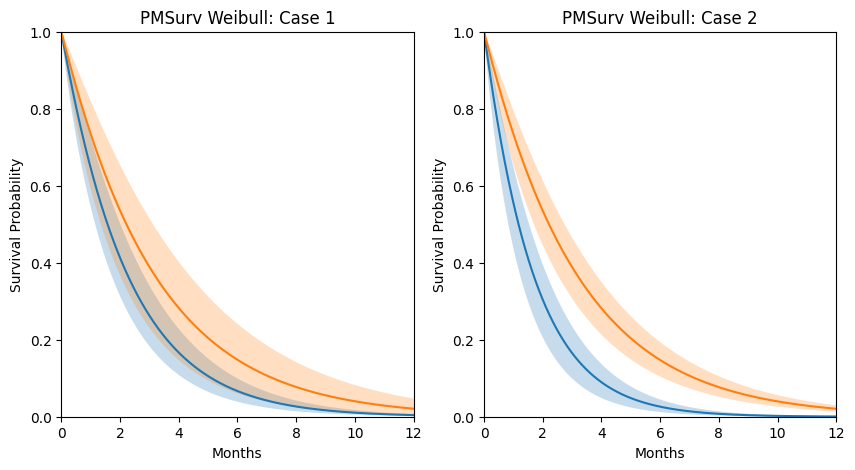

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull: Case 1");
plt.plot(t_plot_wb, surv_wb[0]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[0], y2=surv_wb_upper[0], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[1]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[1], y2=surv_wb_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull: Case 2");
plt.plot(t_plot_wb, surv_wb[2]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[2], y2=surv_wb_upper[2], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[3]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[3], y2=surv_wb_upper[3], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

# Weibull NN

In [22]:
# RETRAIN = True

In [23]:
if RETRAIN:
    metrics, model_nn, best_params_nn, scaler_nn, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull_nn.preprocess_data, pmsurv_weibull_nn.train_model)
    print(f"score {metrics:0.3f}")

In [24]:
if RETRAIN:
    joblib.dump(model_nn['selector'], 'models/nn2/selector.pkl')
    joblib.dump(scaler_nn, 'models/nn2/scaler.pkl')
    model_nn['model'].save('models/nn2/model.yaml')

In [25]:
RETRAIN = False

In [26]:
model_nn_m = WeibullModelLinear()
model_nn_m.load('models/nn2/model.yaml')
model_nn = Pipeline([
    ('selector', joblib.load('models/nn2/selector.pkl')),
    ('model', model_nn_m),
])

scaler_nn = joblib.load('models/nn2/scaler.pkl')

load:  {'coefs_mu': 0, 'coefs_sd': 0.25, 'k_coefs': False, 'k_mu': 1, 'k_sd': 10, 'lambda_coefs_mu': 0, 'lambda_coefs_sd': 0.25, 'lambda_mu': 1, 'lambda_sd': 10, 'n_hidden_layers': [7]}


In [27]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_nn.transform(X_predict[continuous_features])
surv_nn, surv_nn_lower, surv_nn_upper = model_nn.predict(X_predict)
t_plot_nn = pmsurv.utils.get_time_axis(0, model_nn['model'].max_time, 10) / 30.25

Sampling: [lambda_column_0, lambda_column_1, lambda_column_2, lambda_column_3, lambda_column_4, lambda_column_5, lambda_column_6]
INFO:pymc:Sampling: [lambda_column_0, lambda_column_1, lambda_column_2, lambda_column_3, lambda_column_4, lambda_column_5, lambda_column_6]


## Plot

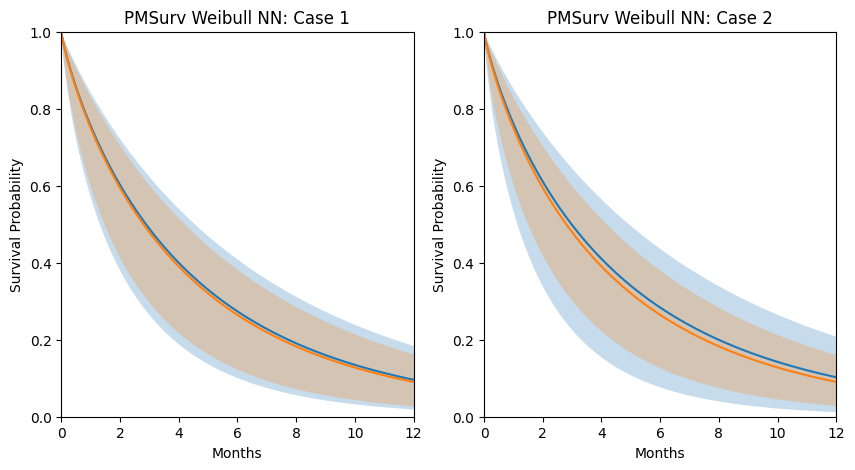

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull NN: Case 1");
plt.plot(t_plot_nn, surv_nn[0]);
plt.fill_between(t_plot_nn, y1=surv_nn_lower[0], y2=surv_nn_upper[0], alpha=0.25);
plt.plot(t_plot_nn, surv_nn[1]);
plt.fill_between(t_plot_nn, y1=surv_nn_lower[1], y2=surv_nn_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull NN: Case 2");
plt.plot(t_plot_nn, surv_nn[2]);
plt.fill_between(t_plot_nn, y1=surv_nn_lower[2], y2=surv_nn_upper[2], alpha=0.25);
plt.plot(t_plot_nn, surv_nn[3]);
plt.fill_between(t_plot_nn, y1=surv_nn_lower[3], y2=surv_nn_upper[3], alpha=0.25);
plt.ylim(0, 1)
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

# Cox PH

In [29]:
import coxph

In [30]:
if RETRAIN:
    metrics, model_cox, best_params_cox, scaler_cox, _ = train_model_generic(dataset, config, train_kwargs, coxph.preprocess_data, coxph.train_model)
    print(f"Score = {metrics:0.3f}");

In [31]:
if RETRAIN:
    joblib.dump(model_cox, 'models/cox/model.pkl')
    joblib.dump(scaler_cox, 'models/cox/scaler.pkl')

In [32]:
model_cox = joblib.load('models/cox/model.pkl')
scaler_cox = joblib.load('models/cox/scaler.pkl')

In [33]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_cox.transform(X_predict[continuous_features])
surv_cox_ = model_cox.predict_survival_function(X_predict)
t_plot_cox = [surv_cox_[0].x, surv_cox_[1].x, surv_cox_[2].x, surv_cox_[3].x]
surv_cox = [surv_cox_[0].y, surv_cox_[1].y, surv_cox_[2].y, surv_cox_[3].y]

# DeepSurv

In [34]:
if RETRAIN:
    metrics, model_dp, best_params_dp, scaler_dp, _ = train_model_generic(dataset, config, train_kwargs, deepsurv.preprocess_data, deepsurv.train_model)

In [35]:
if RETRAIN:
    joblib.dump(model_dp, 'models/dp/model.pkl')
    joblib.dump(scaler_dp, 'models/dp/scaler.pkl')
model_dp = joblib.load('models/dp/model.pkl')
scaler_dp = joblib.load('models/dp/scaler.pkl')

In [36]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_dp.transform(X_predict[continuous_features])
surv = model_dp.predict(X_predict)
t_plot_dp = np.linspace(0, 1, surv[0].shape[0]) * max(surv[:, 0]) / 30.25
surv_dp = surv

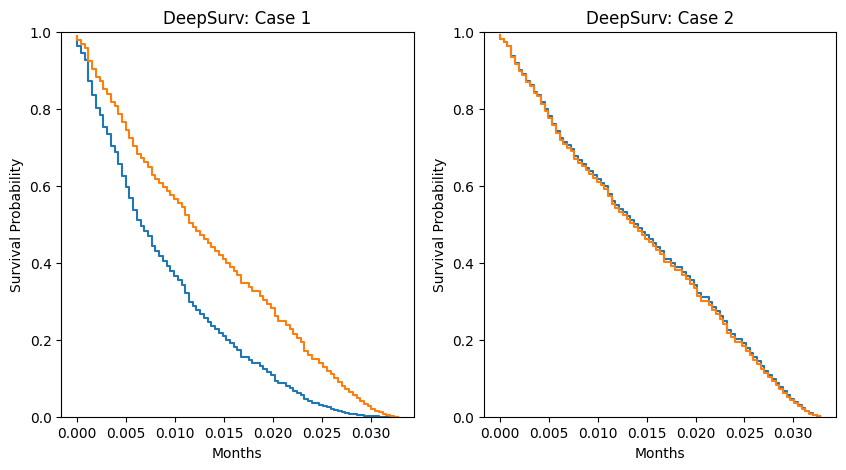

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("DeepSurv: Case 1");
plt.step(t_plot_dp, surv_dp[0]);
plt.step(t_plot_dp, surv_dp[1]);
plt.ylim(0, 1);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("DeepSurv: Case 2");
plt.step(t_plot_dp, surv_dp[2]);
plt.step(t_plot_dp, surv_dp[3]);
plt.ylim(0, 1)
plt.ylabel("Survival Probability");
plt.xlabel("Months");

# RSF

In [38]:
import rsf

In [39]:
if RETRAIN:
    metrics, model_rsf, best_params_rsf, scaler_rsf, _ = train_model_generic(dataset, config, train_kwargs, rsf.preprocess_data, rsf.train_model)
    print(f"Score = {metrics:0.3f}")

In [41]:
if RETRAIN:
    joblib.dump(model_rsf, 'models/rsf/model.pkl')
    joblib.dump(scaler_rsf, 'models/rsf/scaler.pkl')

In [42]:
model_rsf = joblib.load('models/rsf/model.pkl')
scaler_rsf = joblib.load('models/rsf/scaler.pkl')

In [43]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_cox.transform(X_predict[continuous_features])
surv = model_rsf.predict_survival_function(X_predict)
t_plot_rsf = [surv[0].x, surv[1].x, surv[2].x, surv[3].x]
surv_rsf = [surv[0].y, surv[1].y, surv[2].y, surv[3].y]

# Plots

In [44]:
def plot_surv(model_name, case, t_plot, surv, surv_upper, surv_lower, i1, i2, step=False):
    plt.rcParams.update({'font.size': 18, 'font.weight' : 'normal'});

    plt.title(f"{model_name}");
    
    if step:
        plt.step(t_plot, surv[i1]);
    else:
        plt.plot(t_plot, surv[i1]);
    
    if surv_lower is not None:
        plt.fill_between(t_plot, y1=surv_lower[i1], y2=surv_upper[i1], alpha=0.25);
    
    if step:
        plt.step(t_plot, surv[i2]);
    else:
        plt.plot(t_plot, surv[i2]);
    
    if surv_lower is not None:
        plt.fill_between(t_plot, y1=surv_lower[i2], y2=surv_upper[i2], alpha=0.25);
    plt.xticks([0, 3, 6, 9, 12])
    plt.ylim(0, 1);
    plt.ylabel("Survival Probability");
    plt.xlabel("Months");
    plt.xlim(0, 12);


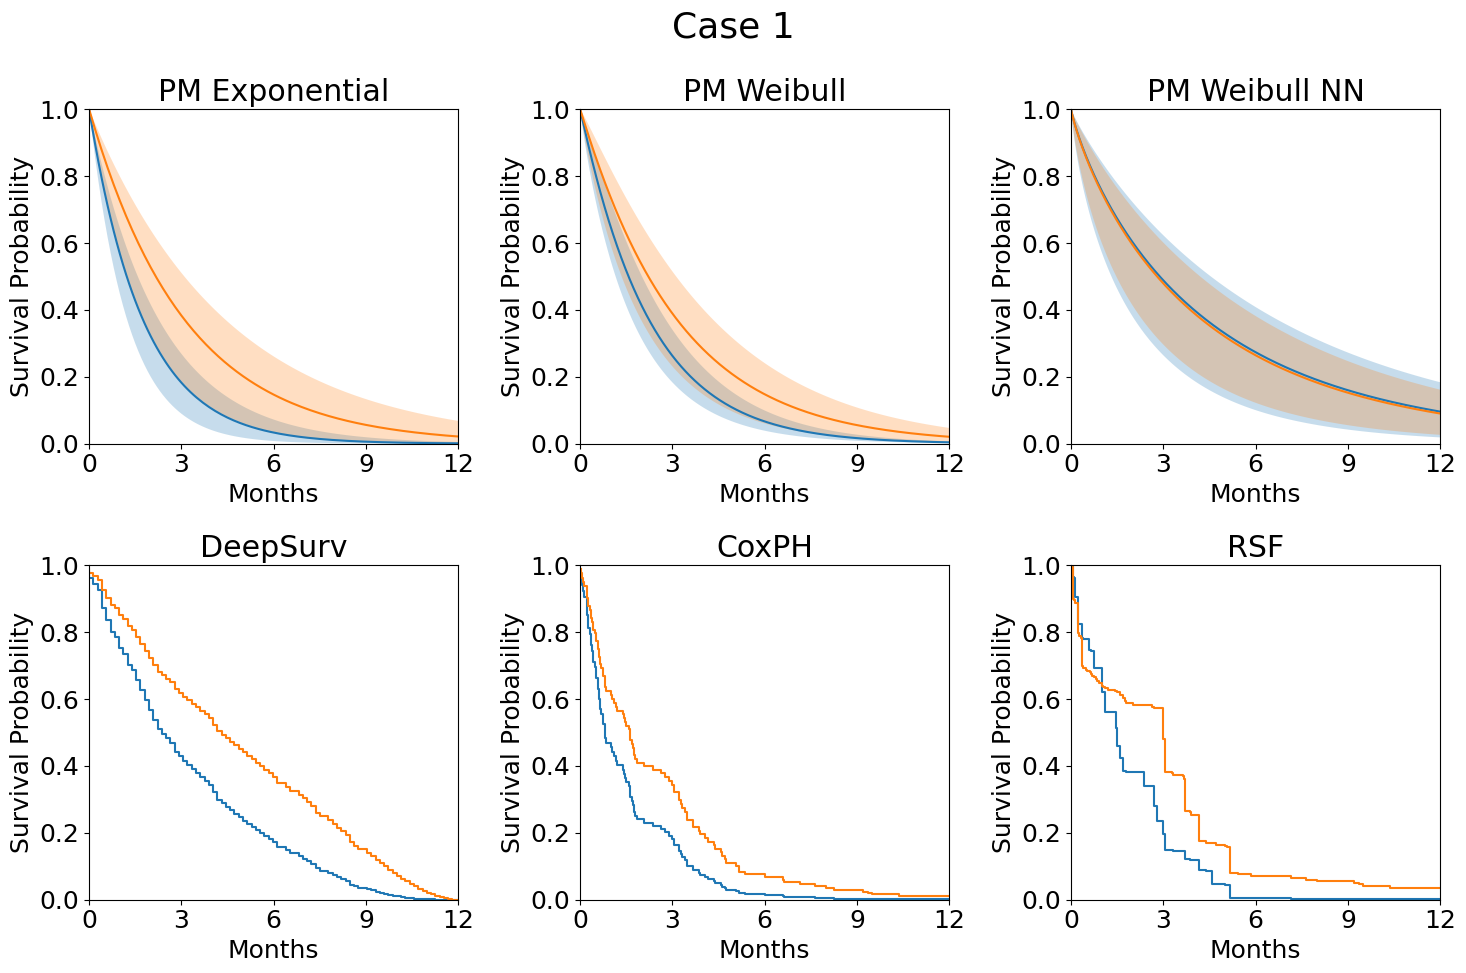

In [56]:
plt.figure(figsize=(15, 10))
plt.suptitle('Case 1', fontsize=26)

plt.rcParams.update({'font.size': 18, 'font.weight' : 'normal'});
plt.subplot(2, 3, 1);
plot_surv("PM Exponential", "Case 1", t_plot_e, surv_e, surv_e_upper, surv_e_lower, 0, 1);
plt.subplot(2, 3, 2);
plot_surv("PM Weibull", "Case 1", t_plot_wb, surv_wb, surv_wb_upper, surv_wb_lower, 0, 1);
plt.subplot(2, 3, 3);
plot_surv("PM Weibull NN", "Case 1", t_plot_nn, surv_nn, surv_nn_upper, surv_nn_lower, 0, 1);

plt.subplot(2, 3, 4);
plot_surv("DeepSurv", "Case 1", t_plot_dp*365, surv_dp, None, None, 0, 1, step=True);
plt.subplot(2, 3, 5);
plot_surv("CoxPH", "Case 1", t_plot_cox[0]/30.25, surv_cox, None, None, 0, 1, step=True);
plt.subplot(2, 3, 6);
plot_surv("RSF", "Case 1", t_plot_rsf[0]/30.25, surv_rsf, None, None, 0, 1, step=True);

plt.tight_layout()

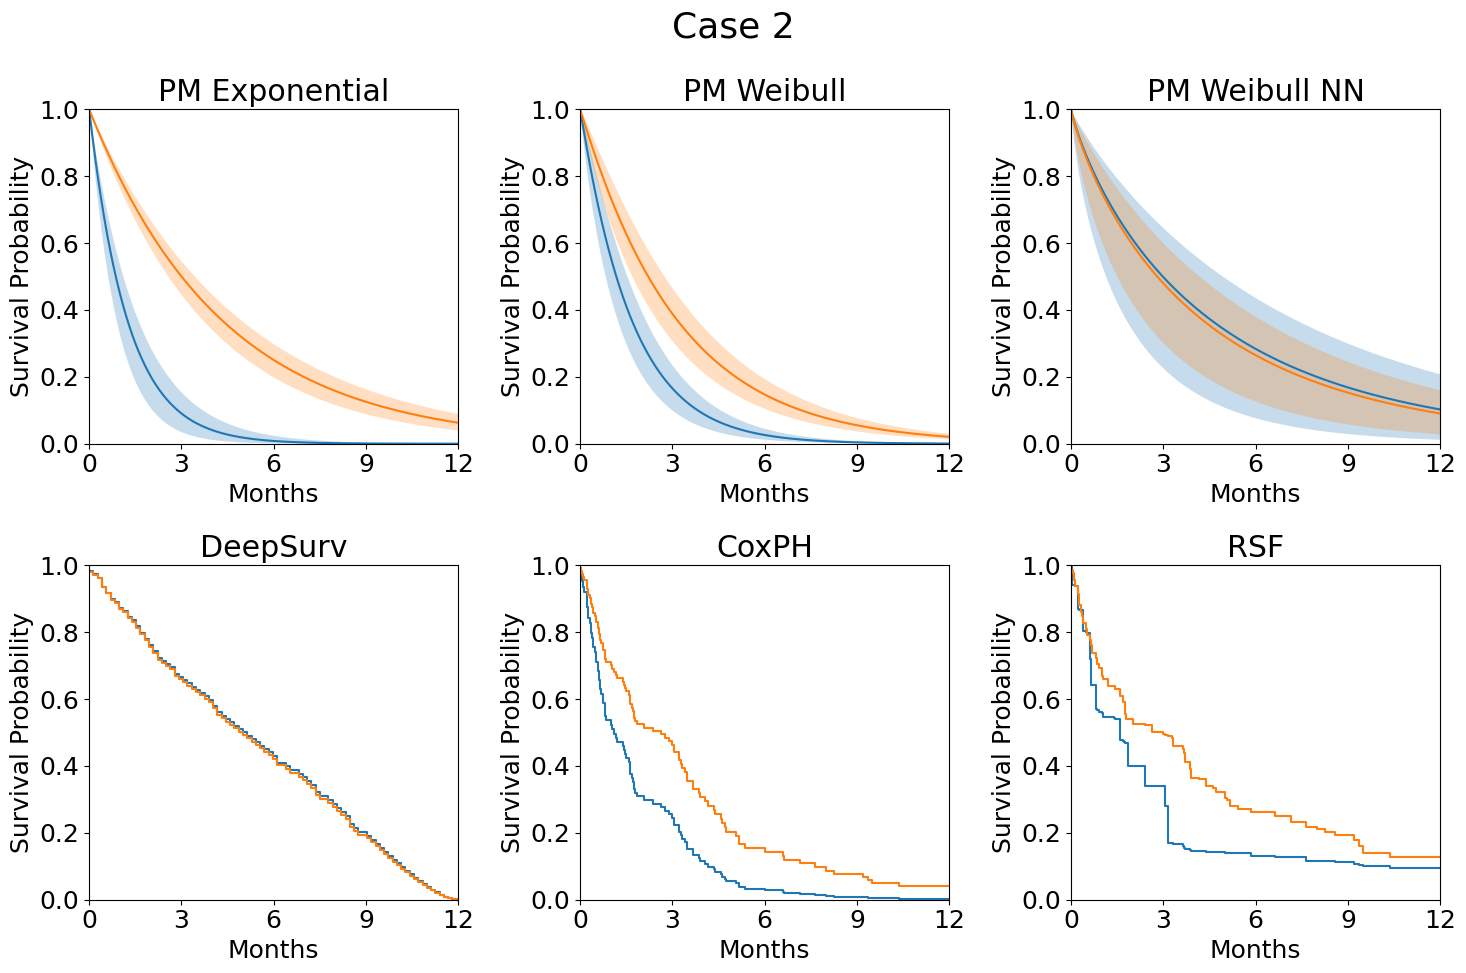

In [46]:
plt.figure(figsize=(15, 10))
plt.suptitle('Case 2', fontsize=26)

idx_1, idx_2 = 2, 3
plt.subplot(2, 3, 1)
plot_surv("PM Exponential", "Case 2", t_plot_e, surv_e, surv_e_upper, surv_e_lower, idx_1, idx_2);
plt.subplot(2, 3, 2)
plot_surv("PM Weibull", "Case 2", t_plot_wb, surv_wb, surv_wb_upper, surv_wb_lower, idx_1, idx_2);
plt.subplot(2, 3, 3)
plot_surv("PM Weibull NN", "Case 2", t_plot_nn, surv_nn, surv_nn_upper, surv_nn_lower, idx_1, idx_2);

plt.subplot(2, 3, 4)
plot_surv("DeepSurv", "Case 2", t_plot_dp*365, surv_dp, None, None, idx_1, idx_2, step=True);
plt.subplot(2, 3, 5)
plot_surv("CoxPH", "Case 2", t_plot_cox[0]/30.25, surv_cox, None, None, idx_1, idx_2, step=True);
plt.subplot(2, 3, 6)
plot_surv("RSF", "Case 2", t_plot_rsf[0]/30.25, surv_rsf, None, None, idx_1, idx_2, step=True);
plt.tight_layout()